<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/actual_pre_training_refactor/Copy_of_LMP_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -q
!pip install pathy -q

     |████████████████████████████████| 122kB 9.3MB/s 


In [ ]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='DRIVE', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='TPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=512, type=int)
parser.add_argument('-la', '--actor_layer_size', default=2048, type=int, help='Layer size of actor, increases size of neural net')
parser.add_argument('-le', '--encoder_layer_size', default=512, type=int, help='Layer size of encoder, increases size of neural net')
parser.add_argument('-lp', '--planner_layer_size', default=512, type=int, help='Layer size of planner, increases size of neural net')
parser.add_argument('-z', '--latent_dim', default=256, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=100000)
parser.add_argument('-r', '--resume', default=False, action='store_true')


# args = parser.parse_args()

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_test
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-tfr
-s GCS
-d TPU
-b 512
-la 2048
-le 512
-lp 2048
-z 256
-lr 3e-4
'''.split())

## Sample colab config
args = parser.parse_args('''
refactor_from_working
--train_dataset UR5 UR5_slow_gripper UR5_high_transition
--test_dataset UR5_slow_gripper_test
-c
-s DRIVE
-d TPU
-b 512
-la 2048
-le 512
-lp 512
-z 256
-lr 3e-4
'''.split())

print(args)

Namespace(actor_layer_size=2048, batch_size=512, colab=True, data_source='DRIVE', device='TPU', encoder_layer_size=512, from_tfrecords=False, gcbc=False, latent_dim=256, learning_rate=0.0003, num_distribs=None, planner_layer_size=512, qbits=None, resume=False, run_name='refactor_from_working', test_datasets=['UR5_slow_gripper_test'], train_datasets=['UR5', 'UR5_slow_gripper', 'UR5_high_transition'], train_steps=100000)


In [ ]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

# COLAB = False #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
# DEVICE = "CPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
# TRAIN_DATASETS = ["UR5"]#,"UR5_slow_gripper","UR5_high_transition"]
# TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')

TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

Using colab setup
Cloning into 'learning_from_play'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 1714 (delta 7), reused 10 (delta 5), pack-reused 1694
Receiving objects: 100% (1714/1714), 57.56 MiB | 38.73 MiB/s, done.
Resolving deltas: 100% (964/964), done.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Storage path: /content/drive/My Drive/Robotic Learning


# Data Creation

In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if args.device == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.12.165.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.12.165.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.12.165.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [ ]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [ ]:
# Use this to edit modules without needing to restart the kernel
!git pull
import importlib
importlib.reload(lfp.data)
importlib.reload(lfp.model)
importlib.reload(lfp.train)
importlib.reload(lfp.metric)

Already up to date.


<module 'lfp.metric' from '/content/learning_from_play/lfp/metric.py'>

### Config Flags

In [ ]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [ ]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS)
train_dataset = dl.load(train_data)

UR5_high_transition: 100%|██████████| 32/32 [00:00<00:00, 42.41it/s]


{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


In [ ]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS)
valid_dataset = dl.load(valid_data)

UR5_slow_gripper_test: 100%|██████████| 2/2 [00:00<00:00, 35.20it/s]

{   'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}


# Model

# Training Loop

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa
import tensorflow_probability as tfp
tfd = tfp.distributions

import time
import io
import wandb
wandb.login()

wandb: Currently logged in as: sholto (use `wandb login --relogin` to force relogin)


True

In [ ]:
from lfp.metric import MaxMetric, create_metrics, record, log_action_breakdown
# from lfp.train import LFPTrainer

In [ ]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                'goal_dim':dl.goal_dim,
                'act_dim':dl.act_dim,
                'layer_size':args.actor_layer_size, 
                'latent_dim':args.latent_dim}
    
    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        model_params['layer_size'] = args.encoder_layer_size
        encoder = lfp.model.create_encoder(**model_params)
        model_params['layer_size'] = args.planner_layer_size
        planner = lfp.model.create_planner(**model_params)

    optimizer = tf.optimizers.Adam(learning_rate=args.learning_rate)
    trainable_variables = actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables
    return actor, encoder, planner, optimizer, trainable_variables

if args.device=='CPU':
    actor, encoder, planner, optimizer, trainable_variables = train_setup()
else:
    with strategy.scope():
        actor, encoder, planner, optimizer, trainable_variables = train_setup()
        
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

In [ ]:
with strategy.scope():
    nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
    mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
    mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

    def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
        if args.num_distribs is not None:
            per_example_loss = nll_action_loss(labels, predictions) * mask
        else:
            per_example_loss = mae_action_loss(labels, predictions) * mask

        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
        per_example_loss = mae_action_loss(labels, predictions) * mask
        per_example_loss = tf.reduce_sum(per_example_loss, axis=1) / seq_lens  # take mean along the timestep
        return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)


    def compute_regularisation_loss(plan, encoding):
        # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
        reg_loss = tfd.kl_divergence(encoding, plan)  # + KL(plan, encoding)
        return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

    train_loss, valid_loss, actor_grad_norm, encoder_grad_norm, planner_grad_norm, \
    actor_grad_norm_clipped, encoder_grad_norm_clipped, planner_grad_norm_clipped, global_grad_norm, \
    test, test2,  train_act_with_enc_loss, train_act_with_plan_loss, valid_act_with_enc_loss, valid_act_with_plan_loss,\
    train_reg_loss, valid_reg_loss, valid_position_loss,  valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss = create_metrics()


# Now outside strategy .scope
def train_step(inputs, beta, prev_global_grad_norm):
    with tf.GradientTape() as actor_tape, tf.GradientTape() as encoder_tape, tf.GradientTape() as planner_tape:  # separate tapes to simplify grad_norm logging and clipping for stability
        # Todo: figure out mask and seq_lens for new dataset 
        states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], \
                                                 inputs['masks']

        if args.gcbc:
            distrib = actor([states, goals])
            loss = compute_loss(actions, distrib, mask, seq_lens)
            gradients = tape.gradient(loss, actor.trainable_variables)
            optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
        else:
            encoding = encoder([states, actions])
            plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
            z_enc = encoding.sample()
            z_plan = plan.sample()
            z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
            z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))

            enc_policy = actor([states, z_enc_tiled, goals])
            plan_policy = actor([states, z_plan_tiled, goals])

            act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), train_act_with_enc_loss)
            act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), train_act_with_plan_loss)
            reg_loss = record(compute_regularisation_loss(plan, encoding), train_reg_loss)
            loss = act_enc_loss + reg_loss * beta

            actor_gradients = actor_tape.gradient(loss, actor.trainable_variables)
            encoder_gradients = encoder_tape.gradient(loss, encoder.trainable_variables)
            planner_gradients = planner_tape.gradient(loss, planner.trainable_variables)

            actor_norm = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm)
            encoder_norm = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm)
            planner_norm = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm)

            gradients = actor_gradients + encoder_gradients+planner_gradients

            # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
            gradients = tf.cond(tf.linalg.global_norm(gradients) > 3 * prev_global_grad_norm,
                                lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0],
                                lambda: gradients)  # must get[0] as it returns new norm as [1]

            planner_gradients = [g * 10 for g in planner_gradients]

            actor_norm_clipped = record(tf.linalg.global_norm(actor_gradients), actor_grad_norm_clipped)
            encoder_norm_clipped = record(tf.linalg.global_norm(encoder_gradients), encoder_grad_norm_clipped)
            planner_norm_clipped = record(tf.linalg.global_norm(planner_gradients), planner_grad_norm_clipped)

            record(tf.linalg.global_norm(gradients), global_grad_norm)

            optimizer.apply_gradients(zip(gradients,
                                          actor.trainable_variables + encoder.trainable_variables + planner.trainable_variables))


    return record(loss, train_loss)


def test_step(inputs, beta):
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']

    if  args.gcbc:
        policy = actor([states, goals], training=False)
        loss = compute_loss(actions, policy, mask, seq_lens)
        log_action_breakdown(policy, actions, mask, seq_lens, args, dl.quaternion_act, valid_position_loss, valid_max_position_loss, \
                             valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)
    else:
        encoding = encoder([states, actions])
        plan = planner([states[:, 0, :], goals[:, 0,:]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
        z_enc = encoding.sample()
        z_plan = plan.sample()
        z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dl.window_size, 1))
        z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dl.window_size, 1))
        enc_policy = actor([states, z_enc_tiled, goals])
        plan_policy = actor([states, z_plan_tiled, goals])
        act_enc_loss = record(compute_loss(actions, enc_policy, mask, seq_lens), valid_act_with_enc_loss)
        act_plan_loss = record(compute_loss(actions, plan_policy, mask, seq_lens), valid_act_with_plan_loss)
        reg_loss = record(compute_regularisation_loss(plan, encoding), valid_reg_loss)
        loss = act_plan_loss + reg_loss * beta
        log_action_breakdown(plan_policy, actions, mask, seq_lens, args.num_distribs is not None, dl.quaternion_act, valid_position_loss, \
                             valid_max_position_loss, valid_rotation_loss, valid_max_rotation_loss, valid_gripper_loss, compute_MAE)
    if args.gcbc:
        return record(loss, valid_loss)
    else:
        return record(loss,valid_loss), z_enc, z_plan


@tf.function
def distributed_train_step(dataset_inputs, beta, prev_global_grad_norm):
    per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


@tf.function
def distributed_test_step(dataset_inputs, beta):
    if args.gcbc:
        per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
    else:
        per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
        return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

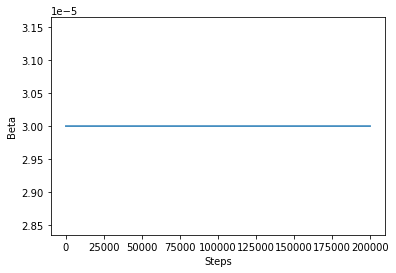

In [ ]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [ ]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [ ]:
actor.summary()
encoder.summary()
planner.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_obs (InputLayer)          [(None, None, 18)]   0                                            
__________________________________________________________________________________________________
input_latent (InputLayer)       [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_goals (InputLayer)        [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 285)    0           input_obs[0][0]                  
                                                                 input_latent[0][0]           

In [ ]:

from lfp.utils import load_weights, load_optimizer_state
import json

def save_weights(path, config=None, run_id=None, step=""):
        os.makedirs(path, exist_ok=True)

        # Save the config as json
        if config is not None:
            print('Saving training config...')
            with open(f'{path}/config.json', 'w') as f:
                d = vars(config)
                d['run_id'] = run_id
                d['relative_act'] = dl.relative_act
                d['joints'] = dl.joints
                d['quaternion_act'] = dl.quaternion_act
                json.dump(d, f)

        actor.save_weights(f'{path}/actor.h5')
        if not config.gcbc:
            encoder.save_weights(f'{path}/encoder.h5')
            planner.save_weights(f'{path}/planner.h5')

        os.makedirs(path+'/optimizers', exist_ok=True)
        np.save(f'{path}/optimizers/optimizer.npy', optimizer.get_weights())


In [ ]:
run_name = args.run_name#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/saved_models/{run_name}/'

if RESUME:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path, strategy)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


train_loss_result,0.02585
valid_loss_result,0.02343
valid_position_loss_result,0.01263
valid_max_position_loss_result,2.64558
valid_rotation_loss_result,0.02648
valid_max_rotation_loss_result,5.75022
valid_gripper_loss_result,0.04665
actor_grad_norm,0.03416
actor_grad_norm_clipped,0.03416
valid_position_loss,0.01263
valid_max_position_loss,2.64558


train_loss_result,▁
valid_loss_result,▁
valid_position_loss_result,▁
valid_max_position_loss_result,▁
valid_rotation_loss_result,▁
valid_max_rotation_loss_result,▁
valid_gripper_loss_result,▁
actor_grad_norm,▁
actor_grad_norm_clipped,▁
valid_position_loss,▁
valid_max_position_loss,▁


In [ ]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset

def log(metric, reset=True):
  result = metric.result()
  if reset:
    metric.reset_states()
  return result

In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if args.gcbc:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result()), ('Time (s)', round(time.time() - start_time, 1))])


        wandb.log({'train_loss_result':log(train_loss, reset=False),
                    'valid_loss_result':log(valid_loss, reset=False),
                    'valid_position_loss_result':log(valid_position_loss, reset=False),
                    'valid_max_position_loss_result':log(valid_max_position_loss, reset=False),
                    'valid_rotation_loss_result':log(valid_rotation_loss, reset=False),
                    'valid_max_rotation_loss_result':log(valid_max_rotation_loss, reset=False),
                    'valid_gripper_loss_result':log(valid_gripper_loss, reset=False),
                    'actor_grad_norm': log(actor_grad_norm),
                    'actor_grad_norm_clipped': log(actor_grad_norm_clipped),
                    'valid_position_loss':log(valid_position_loss),
                    'valid_max_position_loss':log(valid_max_position_loss),
                    'valid_rotation_loss':log(valid_rotation_loss),
                    'valid_max_rotation_loss':log(valid_max_rotation_loss),
                    'valid_gripper_loss':log(valid_gripper_loss),
                  },
                  step=t)
          
        if not args.gcbc:
          wandb.log({
                      'train_act_with_enc_loss_result':log(train_act_with_enc_loss, reset=False),
                      'train_act_with_plan_loss_result':log(train_act_with_plan_loss, reset=False),
                      'train_reg_loss_result':log(train_reg_loss, reset=False),
                      'valid_act_with_enc_loss_result':log(valid_act_with_enc_loss, reset=False),
                      'valid_act_with_plan_loss_result':log(valid_act_with_plan_loss, reset=False),
                      'valid_reg_loss_result':log(valid_reg_loss, reset=False),
                      'beta_result':beta,
                      'encoder_grad_norm': log(encoder_grad_norm),
                      'planner_grad_norm': log(planner_grad_norm),
                      'encoder_grad_norm_clipped': log(encoder_grad_norm_clipped),
                      'planner_grad_norm_clipped': log(planner_grad_norm_clipped),
                      'train_act_with_enc_loss':log(train_act_with_enc_loss),
                      'train_act_with_plan_loss':log(train_act_with_plan_loss),
                      'train_reg_loss':log(train_reg_loss),
                      'valid_act_with_enc_loss':log(valid_act_with_enc_loss),
                      'valid_act_with_plan_loss':log(valid_act_with_plan_loss),
                      'valid_reg_loss':log(valid_reg_loss),
                    },
                    step=t)
          

        prev_grad_norm = log(global_grad_norm)
          
    if t % save_inc == 0:
        save_weights(model_path, args, wandb.run.id)
        if not args.gcbc:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATHS[0], num_take=dl.batch_size//4)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          #latent_fig = project_enc_and_plan(ze, zp)
          #latent_img = plot_to_image(latent_fig)

    t += 1

    40/200000 [..............................] - ETA: 2395:26:04 - Train Loss: 0.0256 - Validation Loss: 0.0233 - Time (s): 59.7000Saving training config...


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you me

    60/200000 [..............................] - ETA: 1664:27:56 - Train Loss: 0.0234 - Validation Loss: 0.0226 - Time (s): 40.7333

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



   680/200000 [..............................] - ETA: 242:21:24 - Train Loss: 0.0098 - Validation Loss: 0.0142 - Time (s): 6.2147

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	learning_from_play/
	wandb/

nothing added to commit but untracked files present (use "git add" to track)
